In [37]:
##import Libraries

import pandas as pd
import matplotlib as plt
import seaborn as sns
from collections import Counter
import numpy as np
import nltk
import string
import re
nltk.download('wordnet')

!pip install wordcloud matplotlib
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import xgboost as xgb
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
##Read the file
from google.colab import files
uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset.csv


In [8]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

#df.tail()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [10]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
!pip install skimpy
from skimpy import skimp
skim(df)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 9.0.0
    Uninstalling pyarrow-9.0.0:
      Successfully uninstalled pyarrow-9.

ImportError: ignored

In [12]:
##define color palette

my_colors = ["#c6b34e","#95354a", "#57b9a8","#b0ddff", "#426872","#215c97", "#02b6b4","#b05468","#cd9f62","#aaaaaa","#8fce00","#827861"]

# Create a seaborn palette object

my_palette = sns.color_palette(my_colors)

# Use the custom palette with a seaborn function
sns.set_palette(my_palette)

from matplotlib.colors import ListedColormap
colors = ['#ffffcd', '#ffeaa4', '#ffca2a','#c6b34e']

my_cmap = sns.color_palette(colors)
cmap = ListedColormap(colors)



In [13]:
## Find the classification of the output count

sentiment_value_counts = df['sentiment'].value_counts()
print(f'positive sentiment counts:{sentiment_value_counts.get("positive", 0)}')
print(f'negative sentiment counts:{sentiment_value_counts.get("positive", 0)}')



positive sentiment counts:25000
negative sentiment counts:25000


In [14]:
##separating data as X & y

X = df.drop(['sentiment'], axis=1)
y = df['sentiment']

print(X)
print(y)

                                                  review
0      One of the other reviewers has mentioned that ...
1      A wonderful little production. <br /><br />The...
2      I thought this was a wonderful way to spend ti...
3      Basically there's a family where a little boy ...
4      Petter Mattei's "Love in the Time of Money" is...
...                                                  ...
49995  I thought this movie did a down right good job...
49996  Bad plot, bad dialogue, bad acting, idiotic di...
49997  I am a Catholic taught in parochial elementary...
49998  I'm going to have to disagree with the previou...
49999  No one expects the Star Trek movies to be high...

[50000 rows x 1 columns]
0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object


In [15]:
def preprocess_text(text):

  # Define the denoise_text function
    def denoise_text(text):
        text = strip_html(text)
        return text

    # Define the strip_html function
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    # Apply denoising functions
    text = denoise_text(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, hashtags, mentions, and special characters
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers/digits
    text = re.sub(r'\b[0-9]+\b\s*', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    return ' '.join(tokens)

df['processed_review'] = df['review'].apply(preprocess_text)



<ipython-input-15-3cdd1d3b6e95>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [16]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


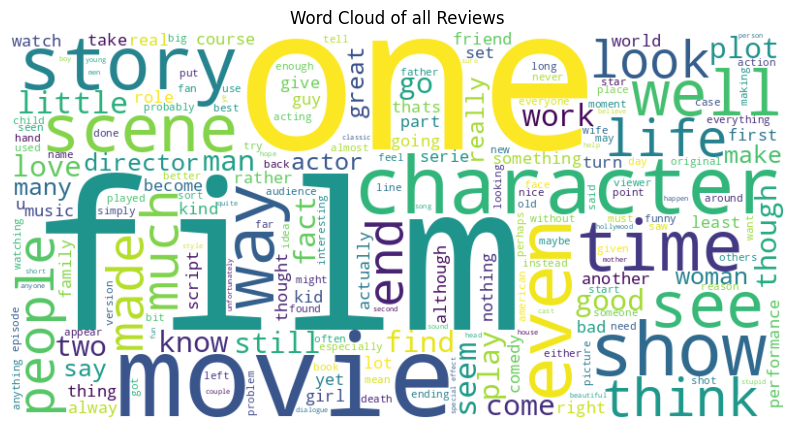

In [ ]:
##build word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data = ' '.join(df['processed_review'])
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of all Reviews')
plt.show()

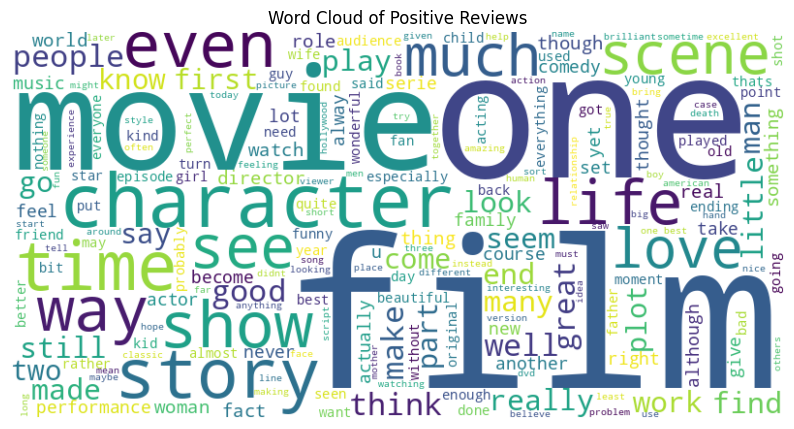

In [ ]:
##build word cloud for positive sentiments

data =' '.join(df[df['sentiment'] == 'positive']['processed_review'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()


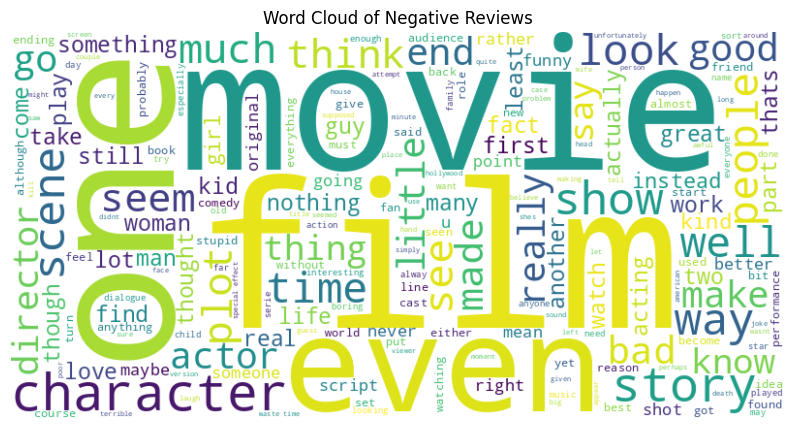

In [ ]:
# Word cloud of negative reviews

data =' '.join(df[df['sentiment'] == 'negative']['processed_review'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


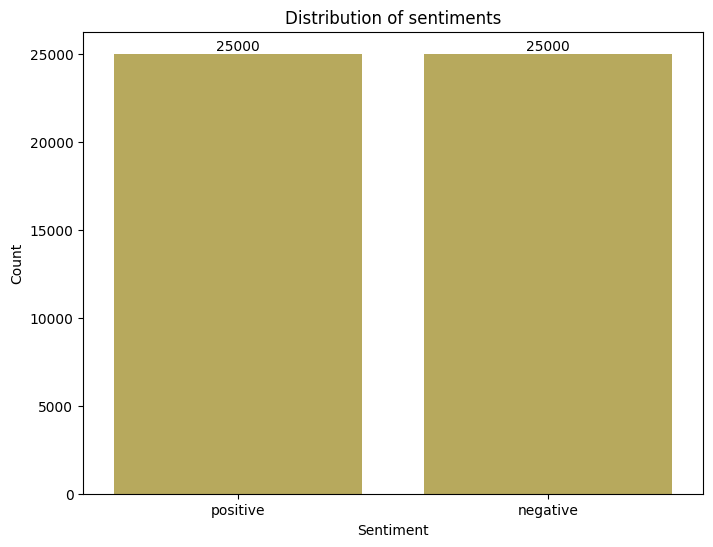

In [ ]:
##bar plot
plt.figure(figsize=(8,6))
color = sns.color_palette()[0]
ax = sns.countplot(data =df, x = 'sentiment', color = color)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of sentiments')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()


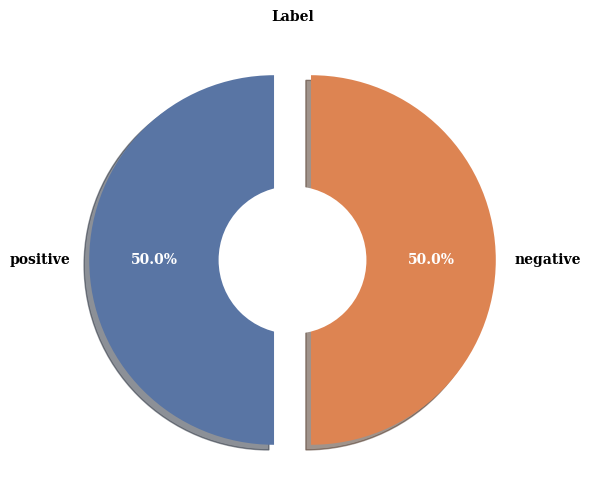

In [ ]:
##Pie plot

label_data = df['sentiment'].value_counts()
explode = (0.1, 0.1)
plt.figure(figsize =(8, 6))
patches, texts, pcts = plt.pie(label_data,
                               labels = label_data.index,
                               colors = ['#5975A4', '#DD8452'],
                               pctdistance = 0.65,
                               shadow = True,
                               startangle=90,
                               explode = explode,
                               autopct = '%1.1f%%',
                               textprops={ 'fontsize': 10,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif' })
plt.setp(pcts, color = 'white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

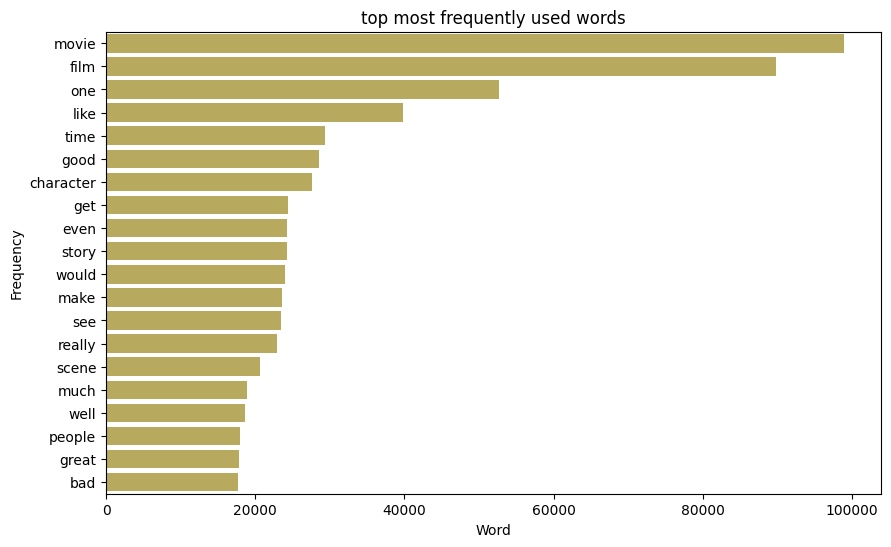

In [ ]:
##most common words in reviews

word_frequency = Counter(" ".join(df['processed_review']).split()).most_common(20)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.barplot(y=[word[0] for word in word_frequency], x=[word[1] for word in word_frequency], color= color)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('top most frequently used words')
plt.show()

In [17]:
X = df['processed_review']
y = df['sentiment']

print(X.shape)

# labeling the sentiment data
lb = LabelBinarizer()
# transformed sentiment data
y = lb.fit_transform(df['sentiment'])
print(y.shape)

(50000,)
(50000, 1)


In [18]:
## splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000,) (40000, 1)
(10000,) (10000, 1)


In [19]:
#XG Boost classifier

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
])

# Model
model = xgb.XGBClassifier(
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
)


# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score: {} %'.format(accuracy*100))

Accuracy score: 85.45 %


In [22]:
#other evaluation metrics
print('Recall score: {:.5f} %' .format(recall_score(y_test , y_pred)*100))
print('Precision score: {:.5f} %' .format(precision_score(y_test , y_pred)*100))
print('Roc_Auc score: {:.5f} %' .format(roc_auc_score(y_test , y_pred)*100))

Recall score: 87.75551 %
Precision score: 84.06844 %
Roc_Auc score: 85.43188 %


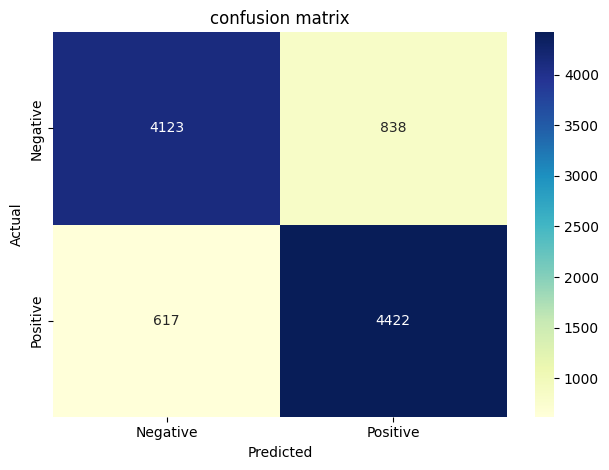

In [30]:
##confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test , y_pred)
#plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot = True, cmap='YlGnBu', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [44]:
##Support vector  machine classifier
#preprocessor

preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidif', TfidfTransformer()),

])

#SVM Model

svm_model = SVC(
    C=1.0,
    kernel= 'linear',
    degree=3,
    coef0=0.0,
    probability= True,
    class_weight='balanced',
)


#pipeline

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svm_model),

])

pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
accuracy_svm = accuracy_score(y_pred, y_pred_svm)
print('Accuracy score: {} %'.format(accuracy_svm*100))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score: 88.25 %


In [45]:
##other evaluation metrics

print('Rcall score: {:.5f} %' .format(recall_score(y_test,y_pred_svm)*100))
print('Precision score: {:.5f} %' .format(precision_score(y_test, y_pred_svm)*100))
print('ROC AUC : {:.5f} %' .format(roc_auc_score(y_test, y_pred_svm)*100))

Rcall score: 90.33538 %
Precision score: 88.54309 %
ROC AUC : 89.23139 %


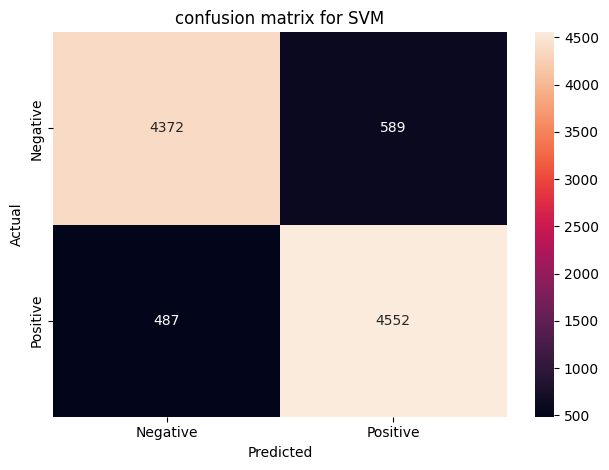

In [51]:
## confusion matrix for the SVM classifier
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_svm)
#plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('confusion matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'comparison of accuracy: SVM vs XGBOOST')

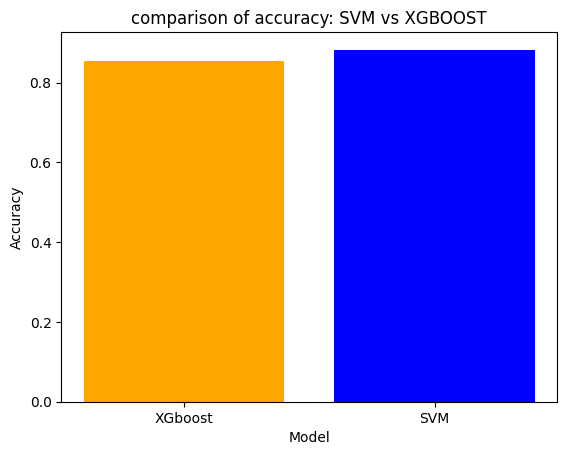

In [54]:
##Display accuracy scores of the models

plt.bar(['XGboost', 'SVM'], [accuracy, accuracy_svm], color =['orange', 'blue'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('comparison of accuracy: SVM vs XGBOOST')

























































































































































